In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pandas.api.types import CategoricalDtype
import seaborn as sns

%load_ext tensorboard
import datetime

from tensorflow.keras.utils import to_categorical

filename = "../../Datasets/WBC/data.csv"

df = pd.read_csv(filename,encoding = 'utf-8')
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [2]:
#df.columns.tolist()
df.rename(columns = {'diagnosis':'class_val'},inplace = True)
df.head(1)
df['class_val'].value_counts()

B    357
M    212
Name: class_val, dtype: int64

In [3]:
# Create category types.
#class_type = CategoricalDtype(['Type1','Type2','Type3'], ordered=True)

# Convert all categorical values to category type.
#df.class_val = df.class_val.astype(class_type)

In [4]:
# Convert categories into integers for each column.
df.class_val=df.class_val.replace({'M':0, 'B':1})

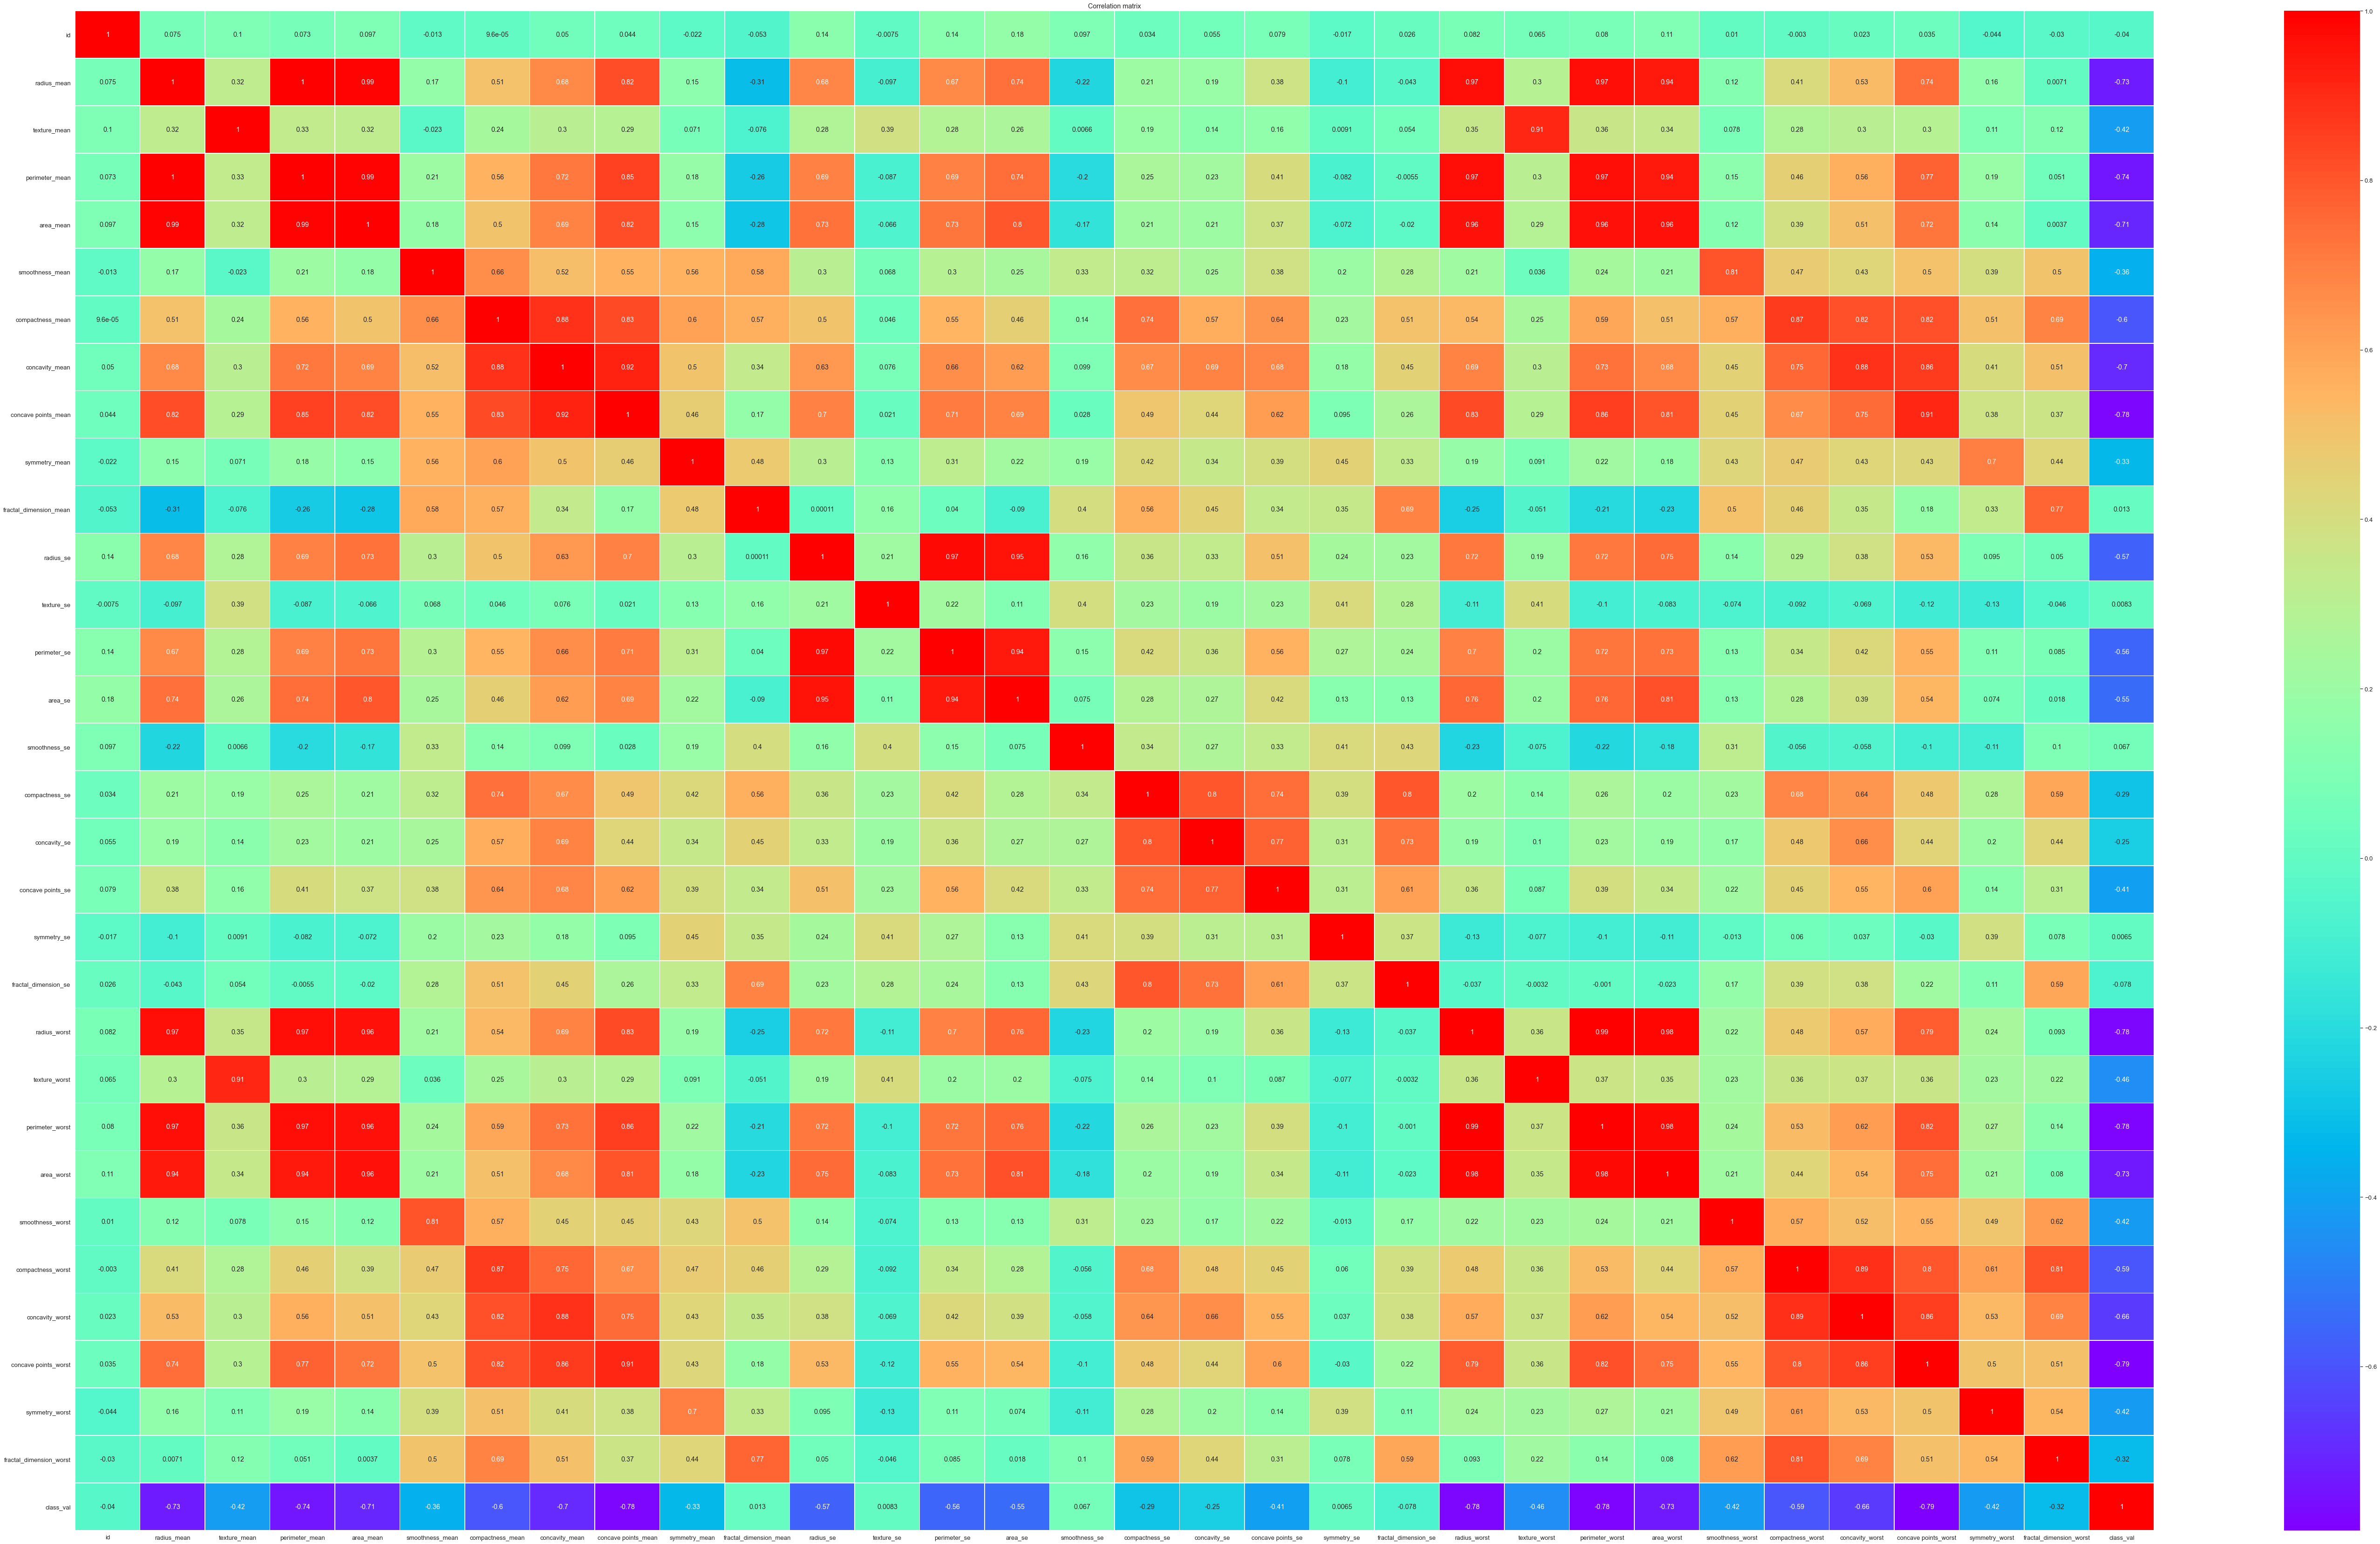

In [5]:
plt.figure(figsize=(100,60))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(),annot=True, cmap='rainbow',linewidth=0.5)
plt.title('Correlation matrix');

In [6]:
# Choose attribute columns and class column.
X=df[df.columns[1:-1]]
y=df['class_val']

y = np.array(y)
y = to_categorical(y)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,class_val
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [7]:
initializer0 = keras.initializers.RandomUniform(minval = 0, maxval =0.005)
initializer1 = keras.initializers.RandomUniform(minval = 0, maxval =0.005)
initializer2 = keras.initializers.RandomUniform(minval = -2, maxval =-1)


class Diffact(keras.layers.Layer):
    def __init__(self):
        super(Diffact, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

from keras import backend as K

class Mish(keras.layers.Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
# split data into train, test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=69, shuffle=True)
#kipping y since value already 1 or 0
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
'''
# normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
'''
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (df.columns)

(512, 30) (512, 2)
(57, 30) (57, 2)
Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'class_val'],
      dtype='object')


In [9]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(25, input_dim=30))
diffact=Diffact()
model.add(diffact)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                775       
_________________________________________________________________
diffact (Diffact)            (None, 25)                3         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 52        
Total params: 830
Trainable params: 830
Non-trainable params: 0
_________________________________________________________________


In [10]:
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

log_dir = "cancerlogs/smallk2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1 ,callbacks=[tensorboard_callback], verbose=1)


Epoch 1/100
 1/92 [..............................] - ETA: 0s - loss: 32079.5371 - accuracy: 0.2000WARNING:tensorflow:From C:\Users\shamb\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
92/92 [==============================] - 0s 5ms/step - loss: 25249.9824 - accuracy: 0.6717 - val_loss: 9149.9941 - val_accuracy: 0.5192
Epoch 2/100
92/92 [==============================] - 0s 2ms/step - loss: 21179.2266 - accuracy: 0.6261 - val_loss: 8162.6357 - val_accuracy: 0.5577
Epoch 3/100
92/92 [==============================] - 0s 2ms/step - loss: 12469.6562 - accuracy: 0.6804 - val_loss: 3371.7271 - val_accuracy: 0.7115
Epoch 4/100
92/92 [==============================] - 0s 2ms/step - loss: 9677.5059 - accuracy: 0.7391 - val_loss: 1340.8795 - val_accuracy: 0.8077
Epoch 5/100
92/92 [======================

92/92 [==============================] - 0s 2ms/step - loss: 57.5775 - accuracy: 0.8978 - val_loss: 46.0006 - val_accuracy: 0.9231
Epoch 54/100
92/92 [==============================] - 0s 1ms/step - loss: 38.5691 - accuracy: 0.9152 - val_loss: 30.1779 - val_accuracy: 0.9423
Epoch 55/100
92/92 [==============================] - 0s 2ms/step - loss: 36.2534 - accuracy: 0.9043 - val_loss: 25.1954 - val_accuracy: 0.9423
Epoch 56/100
92/92 [==============================] - 0s 2ms/step - loss: 28.1843 - accuracy: 0.8848 - val_loss: 23.2902 - val_accuracy: 0.9231
Epoch 57/100
92/92 [==============================] - 0s 1ms/step - loss: 18.7527 - accuracy: 0.9000 - val_loss: 21.1678 - val_accuracy: 0.9231
Epoch 58/100
92/92 [==============================] - 0s 2ms/step - loss: 15.3346 - accuracy: 0.9109 - val_loss: 16.3323 - val_accuracy: 0.9231
Epoch 59/100
92/92 [==============================] - 0s 2ms/step - loss: 16.1647 - accuracy: 0.8891 - val_loss: 12.4322 - val_accuracy: 0.9231
Epoch

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.39530235528945923
Test accuracy: 0.9122806787490845


In [12]:
print("AF coefficients (weights) {}".format(diffact.get_weights()))

AF coefficients (weights) [1.182123, 0.3587381, -0.0040036445]


In [15]:
%tensorboard --logdir cancerlogs/smallk2 --port=6034

Reusing TensorBoard on port 6034 (pid 17696), started 0:00:53 ago. (Use '!kill 17696' to kill it.)

In [14]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,class_val
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000
